# SSH changes

In [30]:
import cmocean 
import cosima_cookbook as cc
import dask.distributed as dsk
import gsw
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

figdir = '/home/561/jn8053/g_e14/figures-tmp/easterlies-collaborative/'

clnt = dsk.Client()
clnt

Client Scheduler: tcp://127.0.0.1:41835 Dashboard: /proxy/46643/status,Cluster Workers: 8 Cores: 48 Memory: 188.57 GiB


Load datasets

In [2]:
session_ryf = cc.database.create_session()
experiment_ryf = '01deg_jra55v13_ryf9091'
session_eas = cc.database.create_session('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db')
experiment_eup = '01deg_jra55v13_ryf9091_easterlies_up10'
experiment_edo = '01deg_jra55v13_ryf9091_easterlies_down10'

ti = '2150-01-01'
tf = '2164-12-31'

In [3]:
ht = cc.querying.getvar(experiment_ryf, 'ht', session_ryf, n = 1).sel(yt_ocean = slice(None, -58))
iso = xr.open_dataset('~/g_e14/misc/Antarctic_isobath_1000m.nc')

In [16]:
slev = {}
slev['ctrl'] = cc.querying.getvar(experiment_ryf, 'sea_level', session_ryf, start_time = ti, end_time = tf).sel(yt_ocean = slice(None, -58))
slev['up'] = cc.querying.getvar(experiment_eup, 'sea_level', session_eas, start_time = ti, end_time = tf).sel(yt_ocean = slice(None, -58))
slev['down'] = cc.querying.getvar(experiment_edo, 'sea_level', session_eas, start_time = ti, end_time = tf).sel(yt_ocean = slice(None, -58))

In [4]:
temp = {}
salt = {}
temp['ctrl'] = cc.querying.getvar(experiment_ryf, 'temp', session_ryf, frequency = '1 monthly', start_time = ti, end_time = tf).sel(yt_ocean = slice(None, -58))-273.15
temp['up'] = cc.querying.getvar(experiment_eup, 'temp', session_eas, frequency = '1 monthly', start_time = ti, end_time = tf).sel(yt_ocean = slice(None, -58))-273.15
temp['down'] = cc.querying.getvar(experiment_edo, 'temp', session_eas, frequency = '1 monthly', start_time = ti, end_time = tf).sel(yt_ocean = slice(None, -58))-273.15
salt['ctrl'] = cc.querying.getvar(experiment_ryf, 'salt', session_ryf, frequency = '1 monthly', start_time = ti, end_time = tf).sel(yt_ocean = slice(None, -58))
salt['up'] = cc.querying.getvar(experiment_eup, 'salt', session_eas, frequency = '1 monthly', start_time = ti, end_time = tf).sel(yt_ocean = slice(None, -58))
salt['down'] = cc.querying.getvar(experiment_edo, 'salt', session_eas, frequency = '1 monthly', start_time = ti, end_time = tf).sel(yt_ocean = slice(None, -58))

# Time series for continental shelf

In [17]:
lat_slice = slice(-80,-58)
lon_slice = slice(-280, 80)

def shelf_mask_isobath(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    # Mask values that are non-zero
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map = xr.DataArray(shelf_map, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    # Multiply the variable with the mask, we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = lat_slice) * shelf_mask
    return masked_var, shelf_map

In [37]:
slev_mask = {}
for k in ['ctrl', 'up', 'down']:
    slev_mask[k], shelf_mask = shelf_mask_isobath(slev[k])

In [19]:
# Area for weighting
area_t = cc.querying.getvar(experiment_ryf, 'area_t', session_ryf, ncfile = 'ocean_grid.nc', n = -1)
area_t = area_t.sel(yt_ocean = lat_slice).sel(xt_ocean = lon_slice)
area_t = area_t * shelf_mask.sel(yt_ocean = lat_slice).sel(xt_ocean = lon_slice)
area_sum = area_t.sum('xt_ocean').sum('yt_ocean')

In [38]:
slev_clim_control = ((slev_mask['ctrl']*area_t).sum('xt_ocean').sum('yt_ocean') / area_sum).groupby('time.month').mean('time')
slev_anom_mask = {}
for k in ['up', 'down']:
    slev_anom_mask[k] = ((slev_mask[k]*area_t).sum('xt_ocean').sum('yt_ocean') / area_sum).groupby('time.month') - slev_clim_control

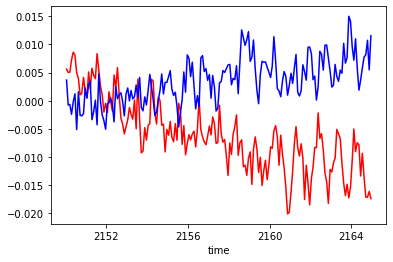

In [29]:
slev_anom_mask['up'].plot(color = 'r')
slev_anom_mask['down'].plot(color = 'b')

# Overturning

In [62]:
ty = {}
ty['ctrl'] = cc.querying.getvar(experiment_ryf, 'ty_trans_rho', session_ryf, start_time = ti, end_time = tf).sel(grid_yu_ocean = slice(None, -50))
ty['up'] = cc.querying.getvar(experiment_eup, 'ty_trans_rho', session_eas, start_time = ti, end_time = tf).sel(grid_yu_ocean = slice(None, -50))
ty['down'] = cc.querying.getvar(experiment_edo, 'ty_trans_rho', session_eas, start_time = ti, end_time = tf).sel(grid_yu_ocean = slice(None, -50))

In [63]:
psi = {}
for k in ['ctrl', 'up', 'down']:
    psi[k] = ty[k]/(1025*1e6)
    psi[k] = psi[k].sum('grid_xt_ocean')

In [64]:
psi_overturning = {}
for k in ['ctrl', 'up', 'down']:
    psi_overturning[k] = psi[k].cumsum('potrho') - psi[k].sum('potrho')

In [76]:
max_transport = {}
for k in ['ctrl', 'up', 'down']:
    max_transport[k] = -psi_overturning[k].sel(grid_yu_ocean = -55, method = 'nearest').min('potrho')

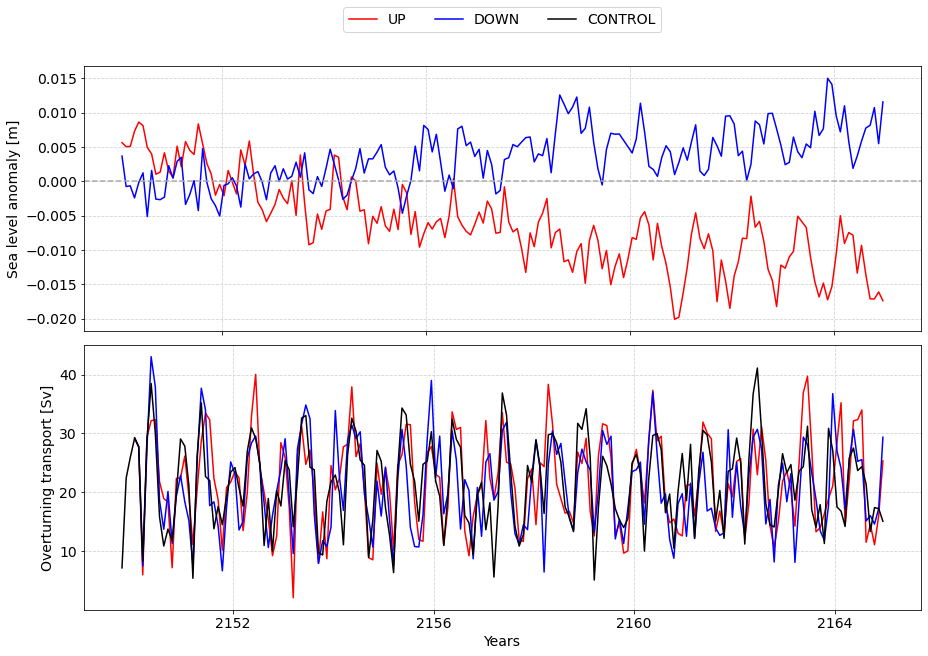

In [85]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (15, 10))
axs = [fig.add_subplot(211), fig.add_subplot(212)]
plt.subplots_adjust(hspace = 0.05)

axs[0].plot(slev_anom_mask['up']['time'], slev_anom_mask['up'], color = 'r')
axs[0].plot(slev_anom_mask['down']['time'], slev_anom_mask['down'], color = 'b')

axs[1].plot(max_transport['up']['time'], max_transport['up'], color = 'r', label = 'UP')
axs[1].plot(max_transport['down']['time'], max_transport['down'], color = 'b', label = 'DOWN')
axs[1].plot(max_transport['ctrl']['time'], max_transport['ctrl'], color = 'k', label = 'CONTROL')
axs[1].legend(ncol = 3, loc = 'upper center', bbox_to_anchor = (0.5,2.3))

axs[0].set_xticklabels([])
axs[0].axhline(y = 0, color = 'darkgrey', linestyle = '--')
axs[0].grid(linestyle = '--', color = 'lightgrey')
axs[1].grid(linestyle = '--', color = 'lightgrey')
axs[0].set_ylabel('Sea level anomaly [m]')
axs[1].set_xlabel('Years')
axs[1].set_ylabel('Overturning transport [Sv]')

plt.savefig(figdir + 'figure2.jpg', bbox_inches = 'tight')

# Steric contributions from temperature and salinity in different layers

Calculated from the separate anomalies of temperature/salinity fields (https://www.mdpi.com/2073-4441/11/10/1987/htm)

$$
\eta_{temp} = \int \frac{\rho(S_{mean}, T, p) - \rho(S_{mean}, T_{mean}, p)}{\rho(S_{mean}, T_{mean}, p)} dz
$$

$$
\eta_{salt} = \int \frac{\rho(S, T_{mean}, p) - \rho(S_{mean}, T_{mean}, p)}{\rho(S_{mean}, T_{mean}, p)} dz
$$

Steps for calculation:
1. Load temp and salinity. Convert to absolute salinity
2. Calculate density anomaly
3. Integrate density anomaly for each layer
4. Average over the shelf

## Upper 100m contribution

In [32]:
temp_surf_ctrl = temp['ctrl'].sel(st_ocean = slice(0, 100))
salt_surf_ctrl = salt['ctrl'].sel(st_ocean = slice(0, 100))
p_ctrl = gsw.p_from_z(-temp_surf_ctrl['st_ocean'], temp_surf_ctrl['yt_ocean'])
salt_abs = gsw.SA_from_SP(salt_surf_ctrl, p_ctrl, salt_surf_ctrl['xt_ocean'], salt_surf_ctrl['yt_ocean'])

# Density changes due to temp/salt changes
ρ_mean_ctrl = gsw.rho(salt_surf_ctrl.mean('time'), temp_surf_ctrl.mean('time'), p_ctrl)
ρ_therm_ctrl = (gsw.rho(salt_surf_ctrl.mean('time'), temp_surf_ctrl, p_ctrl) - ρ_mean_ctrl) / ρ_mean_ctrl
ρ_halos_ctrl = (gsw.rho(salt_surf_ctrl, temp_surf_ctrl.mean('time'), p_ctrl) - ρ_mean_ctrl) / ρ_mean_ctrl

# Height of t-cells
dzt = cc.querying.getvar(experiment_ryf, 'dzt', session_ryf, frequency = '1 monthly', start_time = ti, end_time = tf).sel(yt_ocean = slice(None, -50))-273.15

# Integrating surface layer
slev_therm_surf_ctrl = (ρ_therm_ctrl * dzt.sel(st_ocean = slice(0,100))).sum('st_ocean')
slev_halos_surf_ctrl = (ρ_halos_ctrl * dzt.sel(st_ocean = slice(0,100))).sum('st_ocean')

# Averaging on shelf
slev_therm_surf_shelf_ctrl, shelf_mask = shelf_mask_isobath(slev_therm_surf_ctrl)
slev_therm_surf_shelf_ctrl = (slev_therm_surf_shelf_ctrl*area_t).sum('xt_ocean').sum('yt_ocean') / area_sum

slev_halos_surf_shelf_ctrl, shelf_mask = shelf_mask_isobath(slev_halos_surf_ctrl)
slev_halos_surf_shelf_ctrl = (slev_halos_surf_shelf_ctrl*area_t).sum('xt_ocean').sum('yt_ocean') / area_sum

slev_therm_surf_shelf_ctrl = slev_therm_surf_shelf_ctrl.load() 
slev_halos_surf_shelf_ctrl = slev_halos_surf_shelf_ctrl.load() 

In [34]:
slev_halos_surf_shelf_ctrl.to_netcdf('slev_halos_surf_shelf.nc')
slev_therm_surf_shelf_ctrl.to_netcdf('slev_therm_surf_shelf.nc')

In [22]:
temp_surf = temp['up'].sel(st_ocean = slice(0, 100))
salt_surf = salt['up'].sel(st_ocean = slice(0, 100))
p = gsw.p_from_z(-temp_surf['st_ocean'], temp_surf['yt_ocean'])
salt_abs = gsw.SA_from_SP(salt_surf, p, salt_surf['xt_ocean'], salt_surf['yt_ocean'])

# Density changes due to temp/salt changes
ρ_mean = gsw.rho(salt_surf.mean('time'), temp_surf.mean('time'), p)
ρ_therm = (gsw.rho(salt_surf.mean('time'), temp_surf, p) - ρ_mean) / ρ_mean
ρ_halos = (gsw.rho(salt_surf, temp_surf.mean('time'), p) - ρ_mean) / ρ_mean

# Height of t-cells
dzt = cc.querying.getvar(experiment_eup, 'dzt', session_eas, frequency = '1 monthly', start_time = ti, end_time = tf).sel(yt_ocean = slice(None, -50))-273.15

# Integrating surface layer
slev_therm_surf = (ρ_therm * dzt.sel(st_ocean = slice(0,100))).sum('st_ocean')
slev_halos_surf = (ρ_halos * dzt.sel(st_ocean = slice(0,100))).sum('st_ocean')

# Averaging on shelf
slev_therm_surf_shelf, shelf_mask = shelf_mask_isobath(slev_therm_surf)
slev_therm_surf_shelf = (slev_therm_surf_shelf*area_t).sum('xt_ocean').sum('yt_ocean') / area_sum

slev_halos_surf_shelf, shelf_mask = shelf_mask_isobath(slev_halos_surf)
slev_halos_surf_shelf = (slev_halos_surf_shelf*area_t).sum('xt_ocean').sum('yt_ocean') / area_sum

slev_therm_surf_shelf = slev_therm_surf_shelf.load() 
slev_halos_surf_shelf = slev_halos_surf_shelf.load() 

In [33]:
slev_halos_surf_shelf.to_netcdf('slev_halos_surf_shelf.nc')
slev_therm_surf_shelf.to_netcdf('slev_therm_surf_shelf.nc')

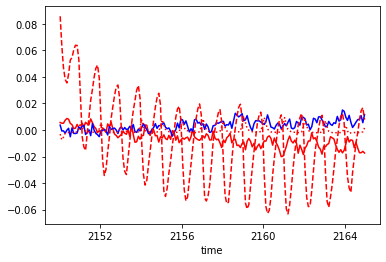

In [40]:
slev_anom_mask['up'].plot(color = 'r')
slev_anom_mask['down'].plot(color = 'b')
(slev_halos_surf_shelf.groupby('time.month')-slev_halos_surf_shelf_ctrl.groupby('time.month').mean('time')).plot(color = 'r', linestyle='--')
(slev_therm_surf_shelf.groupby('time.month')-slev_therm_surf_shelf_ctrl.groupby('time.month').mean('time')).plot(color = 'r', linestyle=':')